In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd

# Scripting experiments

With the new and improved `obd_run.py` and `Experiment` class (see Experiment Interface notebook), we can easily script end to end experiments.

## An OpenBanditDataset experiment

An OpenBanditDataset experiment requires a `dataset_spec.yaml`, `estimator_spec.yaml`, and `policy_spec.yaml`, where the `policy_spec.yaml` can be a _list_ of policies. 

In [2]:
!ls ../experiments/obd_demo/

dataset_spec.yaml   estimator_spec.yaml policy_spec.yaml


In [3]:
!cat ../experiments/obd_demo/policy_spec.yaml

- key: BernoulliTS
  name: obd_demo
  parameters:
    batch_size: 5
    len_list: 3
    n_actions: 3
- key: LinUCB
  name: obd_demo
  parameters:
    dim: 27
    batch_size: 5
    len_list: 3
    n_actions: 3


Then we just point `obp_run.py` at the experiment directory and let it do it's thing!

In [4]:
!python ../scripting/obp_run.py --experiment-dir ../experiments/obd_demo

4:57:31 INFO: Building dataset
4:57:34 INFO: Building policies
4:57:34 INFO: Building estimators
4:57:34 INFO: Running experiment
4:57:34 INFO: Obtaining logged feedback
4:57:34 INFO: Done in 0.0 seconds
4:57:34 INFO: Fitting regression model
4:57:42 INFO: Done in 7.98 seconds
4:57:42 INFO: Running simulations
4:57:42 INFO: [1 of 2] Running simulation for bts
100%|████████████████████████████████| 452949/452949 [00:13<00:00, 33807.42it/s]
4:57:56 INFO: [2 of 2] Running simulation for linear_ucb_0.0
100%|████████████████████████████████| 452949/452949 [00:37<00:00, 12232.00it/s]
4:58:33 INFO: Done in 51.52 seconds
4:58:33 INFO: Estimating rewards
4:58:33 INFO: Estimating reward confidence interval for logged feedback
4:58:34 INFO: [1 of 3] Estimating reward confidence interval for logged
4:58:35 INFO: [2 of 3] Estimating rewards and reward confidence interval for bts
4:58:36 INFO: [3 of 3] Estimating rewards and reward confidence interval for linear_ucb_0.0
4:58:36 INFO: Done in 2.93 se

It drops a `results.pickle` file in the experiments directory with the `OBDExperiment` object.

In [5]:
with open("../experiments/obd_demo/results.pickle","rb") as f:
    obd_results = pickle.load(f)

For a quick summary of the outcomes, we have `reward_summary`:

In [6]:
obd_results.reward_summary

{'logged': {'mean': 0.005126073796387674,
  '95.0% CI (lower)': 0.004940732841887277,
  '95.0% CI (upper)': 0.005346462846810568},
 'bts': {'mean': 0.0053872683460161105,
  '95.0% CI (lower)': 0.00538260774055602,
  '95.0% CI (upper)': 0.005392396666297001},
 'linear_ucb_0.0': {'mean': 0.005327208589589398,
  '95.0% CI (lower)': 0.005321954965442191,
  '95.0% CI (upper)': 0.005331800153828309}}

If we want to dive deeper into the rewards for each policy, we can access the full feedback dictionary for the _logged_ baseline data and partial feedback dictionaries for the _estimated_ policies:

In [7]:
for policy_name, feedback in obd_results.policy_feedback.items():
    print(f"Feedback for {policy_name}:")
    print("\n".join([f"  {key}" for key in feedback.keys()]))

Feedback for logged:
  n_rounds
  n_actions
  action
  position
  reward
  reward_test
  pscore
  context
  action_context
Feedback for bts:
  action
  reward
Feedback for linear_ucb_0.0:
  action
  reward


## A Deezer experiment

Deezer experiments only require a `dataset_spec.yaml` and `policy_spec.yaml`, since they don't use off-policy estimators.

In [8]:
!ls ../experiments/deezer_demo

dataset_spec.yaml policy_spec.yaml


Notice we include the random baseline _as a Random policy_. 

Also notice that extra parameters to pass to DeezerDataset's obtain_batch_bandit_feedback method (like `cascade`, `users_per_batch`, etc) can be included in `meta`.

In [9]:
!cat ../experiments/deezer_demo/policy_spec.yaml

- key: Random
  name: deezer_demo
  parameters:
    len_list: 12
    n_actions: 862
  meta:
    users_per_batch: 1000
- key: BernoulliTS
  name: deezer_demo
  parameters:
    batch_size: 1
    len_list: 12
    n_actions: 862
  meta:
    users_per_batch: 1000
- key: EpsilonGreedy
  name: deezer_demo
  parameters:
    batch_size: 1
    epsilon: 0.1
    len_list: 12
    n_actions: 862
    policy_name: "egreedy_0.1"
  meta:
    users_per_batch: 1000


In [10]:
!python ../scripting/obp_run.py --experiment-dir ../experiments/deezer_demo

4:58:44 INFO: Building dataset
4:59:02 INFO: Building policies
4:59:02 INFO: Running experiment
4:59:02 INFO: Learning and obtaining policy feedback
4:59:02 INFO: [1 of 3] Learning and obtaining random feedback
Simulating online learning: 100%|█████| 100000/100000 [00:16<00:00, 5894.82it/s]
4:59:20 INFO: [2 of 3] Learning and obtaining bts feedback
Simulating online learning: 100%|█████| 100000/100000 [00:29<00:00, 3361.19it/s]
4:59:52 INFO: [3 of 3] Learning and obtaining egreedy_0.1 feedback
Simulating online learning: 100%|█████| 100000/100000 [00:17<00:00, 5759.49it/s]
5:00:11 INFO: Done in 68.68 seconds
5:00:11 INFO: Estimating reward confidence interval for random baseline feedback
5:00:11 INFO: [1 of 3] Estimating reward confindence interval for random feedback
5:00:11 INFO: [2 of 3] Estimating reward confindence interval for bts feedback
5:00:12 INFO: [3 of 3] Estimating reward confindence interval for egreedy_0.1 feedback
5:00:13 INFO: Done in 2.05 seconds
5:00:13 INFO: Experi

Once again we get a `results.pickle` file.

In [11]:
with open("../experiments/deezer_demo/results.pickle","rb") as f:
    deezer_results = pickle.load(f)

And here's the reward summary:

In [12]:
deezer_results.reward_summary

{'random': {'mean': 0.026948960972985,
  '95.0% CI (lower)': 0.02641966290614939,
  '95.0% CI (upper)': 0.02738962686410134},
 'bts': {'mean': 0.2506382996283325,
  '95.0% CI (lower)': 0.24929036553259037,
  '95.0% CI (upper)': 0.2520430705067717},
 'egreedy_0.1': {'mean': 0.05327880660531032,
  '95.0% CI (lower)': 0.052508679141554,
  '95.0% CI (upper)': 0.053848982936960416}}

But sice we learned our bandits online, we have full feedback dictionaries for all of them:

In [13]:
for policy_name, feedback in deezer_results.policy_feedback.items():
    print(f"Feedback for {policy_name}:")
    print("\n".join([f"  {key}" for key in feedback.keys()]))

Feedback for random:
  action
  reward
  position
  context
  action_context
  pscore
  n_rounds
  n_actions
  policy
  selected_actions
  users
  segments
  batches
Feedback for bts:
  action
  reward
  position
  context
  action_context
  pscore
  n_rounds
  n_actions
  policy
  selected_actions
  users
  segments
  batches
Feedback for egreedy_0.1:
  action
  reward
  position
  context
  action_context
  pscore
  n_rounds
  n_actions
  policy
  selected_actions
  users
  segments
  batches


In [14]:
bts = pd.DataFrame(
    {
        "reward": deezer_results.policy_feedback["bts"]["reward"],
        "batch": deezer_results.policy_feedback["bts"]["batches"],
        "pol": "bts"
    }
)
eps = pd.DataFrame(
    {
        "reward": deezer_results.policy_feedback["egreedy_0.1"]["reward"],
        "batch": deezer_results.policy_feedback["egreedy_0.1"]["batches"],
        "pol": "egreedy_0.1"
    }
)


Text(0, 0.5, 'cumulative rewards')

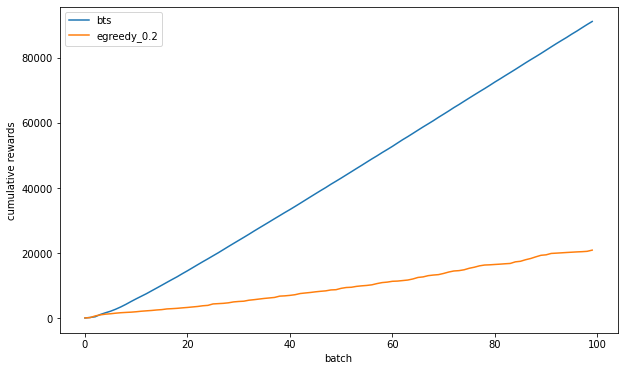

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bts.groupby("batch").sum().cumsum(), label="bts")
ax.plot(eps.groupby("batch").sum().cumsum(), label="egreedy_0.2")
ax.legend()
ax.set_xlabel("batch")
ax.set_ylabel("cumulative rewards")